In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
import seaborn as sns
from gensim.utils import simple_preprocess
import numpy as np
import gensim.parsing.preprocessing as pp
from gensim.models import Word2Vec, KeyedVectors
import gensim

from pymystem3 import Mystem # для лемматизации
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [2]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d13a8fc9a7296413b5669b5830819593bffe7c810717095e191fe652edd2b23c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


# Постановка задачи и загрузка данных

В рамках практики по обработке текста поработаем с реальными данными, содержательно близкими к данным с первой практики, - из Конструктора ОП. В этот раз поработаем с описанием дисциплин с помощью языковых моделей.


Задача на практику - предобработать датасет:
1. получить текстовое описание каждой дисциплины датасета
2. выполнить предобработку текстовых данных
3. построить для дисциплины вектор на основе word2vec
4. потестировать текстовые представления

Задач не много, но все затратные по времени.

In [3]:
!gdown 15tPmdeqzoQNau0NuUATrRnLQBnmb6gA9

Downloading...
From: https://drive.google.com/uc?id=15tPmdeqzoQNau0NuUATrRnLQBnmb6gA9
To: /content/df_up_courses_202308.csv
100% 1.88G/1.88G [00:24<00:00, 76.3MB/s]


Из информации о дисциплине у нас есть следующая:
1. course_id - номер дисциплины (может повторяться)
2. course_title - название дисциплины
3. description - краткое описание дисциплины
4. section - разделы дисциплины
5. topic - темы, входящие в раздел дисциплины
6. qualification - уровень образования (бакалавриат, магистратура, специалитет)
7. unit_id - айди факульета
8. up_id - айди учебного плана (образовательной прогарммы)
9. up_title - название учебного плана (образовательной прогарммы)
10. start_year - год набора
11. module_name - название модуля, в который входит дисциплина

In [4]:
df = pd.read_csv("/content/df_up_courses_202308.csv")
df.head()

,Unnamed: 0,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
0,0,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
1,1,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."
2,2,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,7014,Программирование и интернет-технологии,2020,"Специализация ""Разработка информационных систе..."
3,54,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
4,55,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039709 entries, 0 to 1039708
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1039709 non-null  int64  
 1   course_id      1039709 non-null  int64  
 2   course_title   1039709 non-null  object 
 3   description    1038033 non-null  object 
 4   section        1039709 non-null  object 
 5   topic          1039709 non-null  object 
 6   qualification  1039709 non-null  object 
 7   unit_id        1039709 non-null  float64
 8   up_id          1039709 non-null  int64  
 9   up_title       1039709 non-null  object 
 10  start_year     1039709 non-null  int64  
 11  module_name    1039709 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 95.2+ MB


## Предобработка датасета

Преобразуйте датасет так, чтобы одна строка описывала одну дисциплину в учебном плане. Отдельным столбцом должен храниться весь текст, который описывает дисциплину: description, section, topic. Без дубликатов содержания разделов и тем внутри дисциплины.

In [6]:
def aggregate_texts(series):
    valid_texts = [str(text) for text in series if pd.notnull(text)]
    return '. '.join(set(valid_texts))

df_aggregated = df.groupby(['course_id', 'up_id']).agg({
    'description': aggregate_texts,
    'section': aggregate_texts,
    'topic': aggregate_texts,
    'course_title': 'first',
    'qualification': 'first',
    'unit_id': 'first',
    'up_title': 'first',
    'start_year': 'first',
    'module_name': 'first'
}).reset_index()

df_aggregated

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин
...,...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Дисциплина «Основы планирования научных исслед...,Механимзмы и лучшие практики поиска внешних ко...,Момент принятия решения «Участвую / не участву...,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU)
63965,25732,7255,"The course ""Basics of Research Planning and Ma...",Organising research and preparing applications...,"The ""I want to participate / I can participate...",Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN)
63966,25773,7236,Дифференциальные уравнения являются мощным инс...,Уравнения первого порядка. Уравнения высших по...,Линейные уравнения с постоянными коэффициентам...,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП
63967,30918,7201,Целью освоения дисциплины является достижение ...,Управление функциональной безопасностью. Жизне...,Киберфизические системы. Проблемы обеспечения ...,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины


In [7]:
df_aggregated['full_description'] = df_aggregated[['course_title', 'description', 'section', 'topic']].apply(lambda x: '. '.join(x), axis=1)

In [8]:
df_aggregated

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
...,...,...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Дисциплина «Основы планирования научных исслед...,Механимзмы и лучшие практики поиска внешних ко...,Момент принятия решения «Участвую / не участву...,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...
63965,25732,7255,"The course ""Basics of Research Planning and Ma...",Organising research and preparing applications...,"The ""I want to participate / I can participate...",Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...
63966,25773,7236,Дифференциальные уравнения являются мощным инс...,Уравнения первого порядка. Уравнения высших по...,Линейные уравнения с постоянными коэффициентам...,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...
63967,30918,7201,Целью освоения дисциплины является достижение ...,Управление функциональной безопасностью. Жизне...,Киберфизические системы. Проблемы обеспечения ...,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...


In [9]:
df_aggregated.to_csv('df_to_prep.csv', index=False)

Преобразования выполняются не слишком быстро, рекомендую сохраниться.

## Предобработка описания дисциплины

Пора поработать со столбцом с текстовым содержанием дисциплины. Минимально понадобятся следующие шаги предобработки:
1. Токенизация
2. Удаление пунктуации
3. Лемматизация
4. Удаление лишних пробелов внутри текста

Чтобы не слишком углубляться в предобработку, рекомендую воспользоваться реализованными в gensim методами. Примеры можно найти в ноутбуке по ссылке: https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing

In [10]:
prep_df = pd.read_csv('df_to_prep.csv')

In [11]:
df = pd.read_csv('df_to_prep.csv')

In [12]:
prep_df.head()

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...


In [ ]:
!pip install pymorphy2

In [13]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
import string
from nltk.corpus import stopwords
import pymorphy2

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
analyzer = pymorphy2.MorphAnalyzer()

In [16]:
def text_to_wordlist(text, remove_stopwords=True):
    text = re.sub("[^а-яА-ЯёЁa-zA-Z&]"," ", text)

    words = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("russian") + stopwords.words("english"))
        words = [w for w in words if not w in stops]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    return norm_words

In [17]:
prep_df['prep_description'] = prep_df['full_description'].apply(text_to_wordlist)

In [18]:
prep_df.head()

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."


In [19]:
prep_df.to_csv('prep_df.csv', index=False)

In [ ]:
df['full_description'].iloc[0]

'Философия. Курс «Философия» даёт целостное представление о специфике философии как актуальной формы мышления, о месте и роли философствования в различных средах: повседневной, социальной, коммуникационной, научной.Этот курс для тех, кто хочет узнать, к примеру, о том, что осталось в нашем мышлении неизменным со времен античности, и почему наука, какой мы знаем ее сегодня, не появилась бы без Декарта. Философия для тех, кому важно знать, как избавиться от ошибочных суждений, развить критическое мышление и попробовать себя в роли мастера аргументации в режиме и оффлайн, и онлайн.. Соматическая определенность мышления. Мышление и предметный мир. Социальная определенность мышления. Структуры мышления. Антропоцентризм - постгуманизм - трансгуманизм.. Я и Другой: признание, понимание, коммуникация.. Критическое мышление как задача философии, науки, искусства, повседневных практик.. Техники управления, контроля, манипуляции: возможности распознавания, практики сопротивления.. Субъект мышлени

In [20]:
prep_df['prep_description'].iloc[0]

['философия',
 'курс',
 'философия',
 'давать',
 'целостный',
 'представление',
 'специфика',
 'философия',
 'актуальный',
 'форма',
 'мышление',
 'место',
 'роль',
 'философствование',
 'различный',
 'среда',
 'повседневный',
 'социальный',
 'коммуникационный',
 'научный',
 'курс',
 'тот',
 'хотеть',
 'узнать',
 'пример',
 'остаться',
 'наш',
 'мышление',
 'неизменный',
 'время',
 'античность',
 'почему',
 'наука',
 'знать',
 'сегодня',
 'появиться',
 'декарт',
 'философия',
 'тот',
 'кто',
 'важно',
 'знать',
 'избавиться',
 'ошибочный',
 'суждение',
 'развить',
 'критический',
 'мышление',
 'попробовать',
 'роль',
 'мастер',
 'аргументация',
 'режим',
 'офлайн',
 'онлайн',
 'мышление',
 'предметный',
 'мир',
 'соматический',
 'определённость',
 'мышление',
 'социальный',
 'определённость',
 'мышление',
 'структура',
 'мышление',
 'этический',
 'измерение',
 'наука',
 'искусство',
 'повседневность',
 'телесность',
 'аффективность',
 'мышление',
 'способ',
 'граница',
 'систематизация

Не будет лишним в этот момент сохраниться. Лемматизация выполняется сравнительно долго.

In [ ]:
prep_df.to_csv('prep_df.csv', index=False)

In [21]:
model = Word2Vec(prep_df.prep_description.tolist(), min_count=5, vector_size=300, workers=4, window=10)

In [22]:
model_path = "fin_w2v"
model.save(model_path)

In [23]:
model.wv.get_vector("обучение")

array([-3.894998  ,  0.36365977,  1.997348  , -0.5409349 ,  2.1613326 ,
        7.0027595 ,  2.8957632 ,  2.5799813 ,  3.6988611 , -3.3085008 ,
       -2.3036995 , -1.6636196 ,  4.449289  ,  0.2951092 ,  0.5186495 ,
       -6.319018  ,  0.06042092,  2.5518775 , -3.6929724 ,  2.3798618 ,
       -1.2568617 ,  0.33677518,  2.4571197 ,  2.515659  , -1.772482  ,
       -0.715646  , -0.9849183 ,  1.4543214 , -0.44600153,  3.1942713 ,
        2.2376204 , -6.5924573 ,  4.4330683 ,  2.8342845 , -0.51325905,
        1.6911871 , -1.4301221 , -1.475819  ,  2.37287   ,  1.1303452 ,
        1.5426917 ,  4.8119316 , -3.806819  ,  0.9771216 ,  3.410735  ,
       -3.9647505 ,  0.8787247 , -0.7106159 , -0.13415937,  0.17967197,
        1.085758  , -0.844428  ,  1.076452  ,  2.9092546 , -1.1695396 ,
        2.4102027 , -2.2266107 , -2.1380537 ,  0.8064542 , -1.1892055 ,
       -3.927529  ,  0.95586705, -0.34795123, -1.2971327 , -2.9588547 ,
        2.1742365 , -1.186468  , -1.1551626 , -1.5851946 , -3.05

In [24]:
model.wv.most_similar(["обучение", "машинный"])

[('кластеризация', 0.4991728365421295),
 ('регрессия', 0.4490869641304016),
 ('нейросетевой', 0.44743722677230835),
 ('переобучение', 0.4362960755825043),
 ('тюнинг', 0.4305759072303772),
 ('pytorch', 0.4171934127807617),
 ('бустинг', 0.4124228060245514),
 ('бандит', 0.3873026967048645),
 ('ия', 0.37024107575416565),
 ('многорукий', 0.3701009154319763)]

In [25]:
prep_df[prep_df["course_title"] == "Технологии нейросетевых вычислений"]

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description
3226,2786,6895,Цели освоения дисциплины - приобретение знани...,Введение. Машинное обучение и искусственный ин...,"Основные задачи алгоритмов ИИ, обзор предметно...",Технологии нейросетевых вычислений,bachelor,12.0,Вычислительные системы и сети,2018,"Специализация ""Вычислительные системы""",Технологии нейросетевых вычислений. Цели освое...,"[технология, нейросетевой, вычисление, цель, о..."
3227,2786,6936,Цели освоения дисциплины - приобретение знани...,Введение. Машинное обучение и искусственный ин...,"Основные задачи алгоритмов ИИ, обзор предметно...",Технологии нейросетевых вычислений,bachelor,12.0,Компьютерные системы и технологии,2019,"Специализация ""Вычислительные системы""",Технологии нейросетевых вычислений. Цели освое...,"[технология, нейросетевой, вычисление, цель, о..."
3228,2786,6975,Цели освоения дисциплины - приобретение знани...,Введение. Машинное обучение и искусственный ин...,"Основные задачи алгоритмов ИИ, обзор предметно...",Технологии нейросетевых вычислений,bachelor,12.0,Компьютерные системы и технологии,2020,"Специализация ""Вычислительные системы""",Технологии нейросетевых вычислений. Цели освое...,"[технология, нейросетевой, вычисление, цель, о..."
3229,2786,7137,Цели освоения дисциплины - приобретение знани...,Введение. Машинное обучение и искусственный ин...,"Основные задачи алгоритмов ИИ, обзор предметно...",Технологии нейросетевых вычислений,bachelor,12.0,Компьютерные системы и технологии,2021,"Специализация ""Вычислительные системы""",Технологии нейросетевых вычислений. Цели освое...,"[технология, нейросетевой, вычисление, цель, о..."
3230,2786,7228,Цели освоения дисциплины - приобретение знани...,Введение. Машинное обучение и искусственный ин...,"Основные задачи алгоритмов ИИ, обзор предметно...",Технологии нейросетевых вычислений,bachelor,12.0,Компьютерные системы и технологии,2022,Пул выборных дисциплин 3,Технологии нейросетевых вычислений. Цели освое...,"[технология, нейросетевой, вычисление, цель, о..."


In [26]:
def embed(tokens, w2v_model):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)

In [27]:
embed(prep_df['prep_description'].iloc[0], model)

array([ 1.0711099 , -0.7598642 , -0.00915885, -0.93046474, -0.5762939 ,
        0.11394032, -0.22801407, -0.4263692 , -0.4309517 ,  0.6416035 ,
        0.5172258 , -0.6956507 , -0.29245967, -0.87319356,  0.44213468,
        0.7571692 ,  0.2021418 ,  0.42998463,  1.1774663 ,  0.22589457,
       -0.26911286, -0.8981988 ,  0.13197778, -1.5895833 , -0.2758908 ,
       -0.02187642, -0.13859124, -0.16651084,  0.18162379,  0.17924859,
        0.74323964,  0.2360242 , -0.17989475,  0.61052585,  0.53951937,
       -0.79966986,  0.40597126,  0.2705778 ,  1.1829565 ,  1.1692563 ,
        0.14715919, -0.22839446,  0.01460724,  0.5019207 ,  0.06123081,
       -0.7229278 ,  0.04390583, -0.49846858,  0.02360739, -0.42641917,
       -0.23668581, -1.0957273 ,  0.34198472, -0.3160586 , -0.10546092,
       -0.9728252 ,  0.42284262, -0.01724126,  0.12594649, -0.21497835,
        0.46938503, -0.14521126,  0.19758502,  0.5467406 ,  0.0513922 ,
       -0.6375486 ,  0.20797901, -0.69998133,  0.33931938,  0.72

In [28]:
prep_df["embedding"] = prep_df['prep_description'].apply(lambda x: embed(x, model))
prep_df

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный...","[1.0711099, -0.7598642, -0.009158849, -0.93046..."
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный...","[1.0711099, -0.7598642, -0.009158849, -0.93046..."
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный...","[1.0711099, -0.7598642, -0.009158849, -0.93046..."
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный...","[1.0711099, -0.7598642, -0.009158849, -0.93046..."
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный...","[1.0711099, -0.7598642, -0.009158849, -0.93046..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Дисциплина «Основы планирования научных исслед...,Механимзмы и лучшие практики поиска внешних ко...,Момент принятия решения «Участвую / не участву...,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...,"[основа, планирование, научный, исследование, ...","[0.9003543, 0.31986988, 0.14817943, 0.05916511..."
63965,25732,7255,"The course ""Basics of Research Planning and Ma...",Organising research and preparing applications...,"The ""I want to participate / I can participate...",Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...,"[основа, планирование, научный, исследование, ...","[0.8197803, -0.34850484, 0.34373546, 0.3318106..."
63966,25773,7236,Дифференциальные уравнения являются мощным инс...,Уравнения первого порядка. Уравнения высших по...,Линейные уравнения с постоянными коэффициентам...,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...,"[дифференциальный, уравнение, дифференциальный...","[0.043481518, -0.1347404, -0.6853362, 0.485883..."
63967,30918,7201,Целью освоения дисциплины является достижение ...,Управление функциональной безопасностью. Жизне...,Киберфизические системы. Проблемы обеспечения ...,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...,"[функцион

In [29]:
prep_df.to_csv("embed_df.csv", index=False)

Не забываем сохраниться!

# Задание на ЛР2

С предобработанными данными попытаемся решить следующие задачи:

1. Определить предметные области дисциплин через кластеризацию. Используем два классических алгоритма: k-means и иерархическую кластеризацию.
2. Найти дисциплины, которые выбиваются из учебного плана. Для этого построим эмбеддинг учебного плана (усредним эмбеддинги всех его дисциплин) и найдем дисциплины, у которых минимальное косинусное сходство с эмбеддингом учебного плана.
3. Оценить, насколько удачно будет генерировать содержание дисциплины LLM. Структура описания дисциплины не важна. Важно содержание. Сравнивать будем эмбеддинги снова через косинусное сходство.

In [30]:
df_lab = pd.read_csv("/content/embed_df.csv")
df_lab

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...",[ 1.0711099 -0.7598642 -0.00915885 -0.930464...
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...",[ 1.0711099 -0.7598642 -0.00915885 -0.930464...
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...",[ 1.0711099 -0.7598642 -0.00915885 -0.930464...
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...",[ 1.0711099 -0.7598642 -0.00915885 -0.930464...
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...",[ 1.0711099 -0.7598642 -0.00915885 -0.930464...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Дисциплина «Основы планирования научных исслед...,Механимзмы и лучшие практики поиска внешних ко...,Момент принятия решения «Участвую / не участву...,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...",[ 9.00354326e-01 3.19869876e-01 1.48179427e-...
63965,25732,7255,"The course ""Basics of Research Planning and Ma...",Organising research and preparing applications...,"The ""I want to participate / I can participate...",Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...",[ 8.19780290e-01 -3.48504841e-01 3.43735456e-...
63966,25773,7236,Дифференциальные уравнения являются мощным инс...,Уравнения первого порядка. Уравнения высших по...,Линейные уравнения с постоянными коэффициентам...,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...,"['дифференциальный', 'уравнение', 'дифференциа...",[ 4.3481518e-02 -1.3474040e-01 -6.8533617e-01 ...
63967,30918,7201,Целью освоения дисциплины является достижение ...,Управление функциональной безопасностью. Жизне...,Киберфизические системы. Проблемы обеспечения ...,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...,"['функциональный', 'безопасность', 'ки

## Кластеризация дисциплин

Удалим дубликаты, т.к. нас интересует только содержательный аспект в данной задаче.

In [31]:
def str_to_list(vector_str):
    numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", vector_str)
    vector_list = [float(num) for num in numbers_str]
    return vector_list

df_lab["embedding"] = df_lab["embedding"].apply(str_to_list).apply(lambda x: x[:300])
df_lab["full_description"] = df_lab["full_description"].apply(lambda x: x.replace('..', '.'))

In [32]:
df_to_clust = df_lab.drop_duplicates(subset=["course_id"], keep="first")
f"{df_lab.shape} -> {df_to_clust.shape}"

'(63969, 14) -> (7118, 14)'

In [33]:
X = np.array(df_to_clust['embedding'].tolist())

### k-means

7к объектов - небольшое количество для кластеризации, обучение будет проходить достаточно быстро. Начнем с k-means. В качестве меры сходства будем использовать косинусное расстояние. Другие виды расстояния будут мало репрезентативны на векторах размером 300.

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10,           # ни на чем не основанное предположение, что у нас 10 кластеров
                random_state=0,
                n_init="auto",
                algorithm="lloyd").fit(X) # lloyd означает, что возьмем не совсем k-means, а ЕМ - более общую версию алгоритма
kmeans.labels_

array([1, 7, 1, ..., 6, 0, 7], dtype=int32)

In [35]:
df_to_clust["cluster"] = kmeans.labels_

<ipython-input-35-9d0e96553b6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_clust["cluster"] = kmeans.labels_


In [36]:
df_to_clust.cluster.value_counts()

1    3425
7     606
8     546
0     479
2     449
9     396
4     355
5     328
3     316
6     218
Name: cluster, dtype: int64

In [37]:
df_to_clust.to_csv("df_to_clust.csv", index=False)
df_to_clust

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...",1
6,2627,7146,"Курс ""Введение в цифровую культуру и программи...",Управление разработкой в ИТ. Базовые инструмен...,Инструментарий разработчика. IDE. CI_CD. Систе...,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[-1.32818609, 1.0, -1.80258706, 1.0, 5.2649810...",7
7,2628,6881,Дисциплина направлена на формирование понимани...,Введение. Реализация систем управления базами ...,Сложные запросы к БД Деканат. Процедуры и функ...,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[0.29277602, -0.2072225, -0.4620403, 0.3256944...",1
11,2631,6881,Дисциплина направлена на формирование системат...,Линейные коды. Сверточные коды. Коды с малой п...,Линейные коды. Сверточные коды. Коды с малой п...,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[1.48781165, 1.0, 5.47151685, 1.0, 8.9022316, ...",9
14,2635,6859,Целью освоения дисциплины является достижение ...,Иностранный язык для академических целей. Осно...,Исторические процессы и события.. Технологии б...,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[4.63760674, 1.0, 7.72395194, 1.0, 1.96419179,...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63962,25728,7226,Курс фокусируется на значимых отечественных ис...,Реформы и реформаторы в Советском Союзе и Росс...,Российская Федерация в 1990-х гг.: формировани...,Реформы и реформаторы в истории России,bachelor,41.0,Компьютерные технологии: Программирование и ис...,2022,История России (3 сем.),Реформы и реформаторы в истории России. Курс ф...,"['реформа', 'реформатор', 'история', 'россия',...","[0.9703782, -0.4215817, -0.27496126, -1.008006...",1
63964,25731,7255,Дисциплина «Основы планирования научных исслед...,Механимзмы и лучшие практики поиска внешних ко...,Момент принятия решения «Участвую / не участву...,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...","[9.00354326, 1.0, 3.19869876, 1.0, 1.48179427,...",3
63965,25732,7255,"The course ""Basics of Research Planning and Ma...",Organising research and preparing applications...,"The ""I want to participate / I can participate...",Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...","[8.1978029, 1.0, -3.48504841, 1.0, 3.43735456,...",6
63966,25773,7236,Дифференциальные уравнения являются мощным инс...,Уравнения первого порядка. Уравнения высших по...,Линейные уравнения с постоянными коэффициентам...,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязате



> **В коде ниже берутся первые 5 примеров. Посмотрите, что будет на случайных подвыборках.**

In [38]:
for i in range(kmeans.n_clusters):
  display(df_to_clust.loc[df_to_clust.cluster == i].head(5))

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
133,2640,6859,"Дисциплина охватывает круг вопросов, связанных...",Типовые звенья (программа онлайн-курса). Точно...,Структурные схемы и структурные преобразования...,Теория автоматического управления,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления. Дисциплина ...,"['теория', 'автоматический', 'управление', 'ди...","[5.63877106, 1.0, -1.01177287, 0.0, 2.44194642...",0
941,2652,6905,В результате освоения курса студенты получат п...,Линейная алгебра. Аналитическая геометрия,Прямая и плоскость. Теория линейных пространст...,Линейная алгебра,bachelor,2.0,Программирование и интернет-технологии,2018,Математический модуль,Линейная алгебра. В результате освоения курса ...,"['линейный', 'алгебра', 'результат', 'освоение...","[9.34005082, 2.0, 1.7173579, 2.0, 1.29614875, ...",0
957,2655,6905,Дисциплина «Дополнительные главы высшей матема...,Дифференциальные уравнения. Ряды,Метод Лагранжа. Числовые ряды и их свойства. Л...,Дополнительные главы высшей математики,bachelor,2.0,Программирование и интернет-технологии,2018,Математический модуль,Дополнительные главы высшей математики. Дисцип...,"['дополнительный', 'глава', 'высокий', 'матема...","[9.81127173, 2.0, -3.37658674, 1.0, -4.3005839...",0
958,2656,6881,В рамках дисциплины студенты знакомятся с осно...,Нечеткие и имитационные модели. Универсальные ...,Имитационные модели. Применение математических...,Математическое и имитационное моделирование в ...,bachelor,14.0,Информатика и программирование,2018,Естественнонаучный модуль,Математическое и имитационное моделирование в ...,"['математический', 'имитационный', 'моделирова...","[-6.8994746, 2.0, -5.6003124, 1.0, 9.0284276, ...",0
1391,2668,6881,Дисциплина направлена на изучение теории вычис...,"Теория вычислимости, Теория вычислительной сло...",Вероятностные вычисления. Принадлежность NP. N...,Теория вычислительной сложности,bachelor,14.0,Информатика и программирование,2018,Цифровая культура в профессиональной деятельно...,Теория вычислительной сложности. Дисциплина на...,"['теория', 'вычислительный', 'сложность', 'дис...","[7.30257928, 1.0, -2.76204079, 1.0, -1.0626402...",0


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...",1
7,2628,6881,Дисциплина направлена на формирование понимани...,Введение. Реализация систем управления базами ...,Сложные запросы к БД Деканат. Процедуры и функ...,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[0.29277602, -0.2072225, -0.4620403, 0.3256944...",1
91,2637,6859,Данный курс сформирован на основе лучших дост...,Визуальное сопровождение выступления.. Комуник...,Аргументация и аргументы.. Формирование навыка...,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...","['техника', 'публичный', 'выступление', 'перег...","[-0.06331042, 0.57548314, -0.4874388, 0.991223...",1
249,2641,6859,Что общего между умным чайником и металлургиче...,"Высокий уровень разработки КФС. Технологии, пр...",Аппаратная часть кибер-физических систем. Новы...,Основы проектирования киберфизических систем,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Основы проектирования киберфизических систем. ...,"['основа', 'проектирование', 'киберфизический'...","[0.46099976, -0.57028353, 0.20339233, -0.23354...",1
365,2642,6859,Дициплина предназначена для изучения студентам...,Неделя 7. Тестирование программного обеспечени...,Тестирование №1. Контроль и управление рисками...,Методы и средства программного обеспечения,All_levels,12.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Методы и средства программного обеспечения. Ди...,"['метод', 'средство', 'программный', 'обеспече...","[0.27964127, -0.5210116, 0.4829643, 0.4481675,...",1


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
3231,2787,6895,Дисциплина направлена на получение студентами ...,Сертификация. Стандартизация. Метрология,Стандартизация в области обеспечения качества....,"Метрология, стандартизация и сертификация",bachelor,12.0,Вычислительные системы и сети,2018,"Специализация ""Вычислительные системы""","Метрология, стандартизация и сертификация. Дис...","['метрология', 'стандартизация', 'сертификация...","[8.86230826, 1.0, -5.84384561, 1.0, 3.16635847...",2
3364,2830,6902,Содержание дисциплины охватывает круг вопросов...,Природа и общество. Защита окружающей среды,Экобиозащитная техника. Экологический монитори...,Экология,bachelor,6.0,Мобильные и сетевые технологии,2018,Естественнонаучный модуль,Экология. Содержание дисциплины охватывает кру...,"['экология', 'содержание', 'дисциплина', 'охва...","[1.29970193, 0.0, -5.64282894, 1.0, -4.1157960...",2
3732,2968,6885,Дисциплина призвана обеспечить теоретическую п...,Сегментирование. Продвижение и сбыт. Введение ...,Теоретические подходы к исследованию конкуренц...,Инновационный маркетинг,bachelor,1.0,Биоинженерия,2020,ОГНП 4: Предпринимательство и инноватика,Инновационный маркетинг. Дисциплина призвана о...,"['инновационный', 'маркетинг', 'дисциплина', '...","[-6.55024052, 1.0, -1.73969641, 1.0, -3.928255...",2
3846,2982,6879,В данном курс студенты освоят следующие вопрос...,Управление средствами коммуникаций и их функци...,1 Соответствие правовым требованиям: 2 Соответ...,Управление информационной безопасностью,bachelor,13.0,Технологии защиты информации,2018,"Специализация ""Комплексные системы защиты инфо...",Управление информационной безопасностью. В дан...,"['управление', 'информационный', 'безопасность...","[8.06857944, 2.0, -7.20231652, 1.0, -2.1071086...",2
4019,3107,6893,NaN,Перспективные технологии организации и управле...,Определение понятия инновационные производстве...,Технологические инновации в производстве,bachelor,2.0,Цифровые технологии в приборостроении,2018,Факультетский модуль,Технологические инновации в производстве. . Пе...,"['технологический', 'инновация', 'производство...","[6.60365403, 1.0, -1.41603696, 0.0, 2.77846664...",2


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
14,2635,6859,Целью освоения дисциплины является достижение ...,Иностранный язык для академических целей. Осно...,Исторические процессы и события.. Технологии б...,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[4.63760674, 1.0, 7.72395194, 1.0, 1.96419179,...",3
731,2647,6885,В этом курсе вы изучите фундаментальные принци...,Программирование в Linux- системах. Сетевое ад...,Основные концепции и компоненты. Работа над пр...,UNIX/Linux системы в инфокоммуникациях,bachelor,17.0,Биоинженерия,2020,ОГНП 6: Трансляционные информационные технологии,UNIX/Linux системы в инфокоммуникациях. В этом...,"['unix', 'linux', 'система', 'инфокоммуникация...","[1.330861, 1.0, -6.11234784, 1.0, -1.12618424,...",3
2393,2737,6859,Данная дисциплина учит создавать клуб и развив...,Деятельность клуба. Возможности студента в сов...,Проведение мероприятий в рамках деятельности к...,Создание и развитие студенческого клуба,bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Создание и развитие студенческого клуба. Данна...,"['создание', 'развитие', 'студенческий', 'клуб...","[3.34326088, 1.0, -9.38563049, 1.0, 4.1506201,...",3
2949,2752,6876,В рамках дисциплины планируется рассмотрение о...,Кинетическая типографика. Видеоблог. Видеомонт...,Тематическое представление медийного контента....,Мультимедиа технологии,bachelor,12.0,Компьютерные технологии в дизайне,2018,Элективный модуль по группе направлений,Мультимедиа технологии. В рамках дисциплины пл...,"['мультимедиа', 'технология', 'рамка', 'дисцип...","[-3.9579201, 1.0, -2.6643708, 1.0, -2.7715912,...",3
3388,2836,6935,"Дисциплина ""Инфокоммуникационные системы и тех...",Виды профессиональной деятельности. Профессион...,Основы проектной деятельности и ее значение в...,Инфокоммуникационные системы и технологии,bachelor,17.0,Иностранные языки и информационные технологии ...,2021,Модуль обязательных дисциплин,Инфокоммуникационные системы и технологии. Дис...,"['инфокоммуникационный', 'система', 'технологи...","[7.72821307, 1.0, 5.34526587, 1.0, -6.42158151...",3


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
8347,4726,6861,The aim of the discipline “Applied Artificial ...,Selective course: Automatic Text Processing. S...,Reinforcement machine learning. Q-Learning alg...,Прикладной искусственный интеллект (продвинуты...,master,7.0,Молекулярная биология и биотехнология / Molecu...,2021,Цифровая культура в предметной области мегафак...,Прикладной искусственный интеллект (продвинуты...,"['прикладной', 'искусственный', 'интеллект', '...","[3.7794358, 1.0, -7.9346299, 1.0, 2.5520703, 1...",4
8885,4803,7078,The aim of the discipline is to form students'...,"Scientific basis for the production of land, w...",Energy conversion. Heat pumps. The power of he...,Исследование альтернативных источников энергии...,master,6.0,Промышленная экология и чистое производство,2020,"Специализация ""Чистое производство / Cleaner P...",Исследование альтернативных источников энергии...,"['исследование', 'альтернативный', 'источник',...","[3.13831478, 1.0, -4.31995928, 1.0, 5.20651281...",4
8910,4845,6861,Students will know the structural and function...,Artificial systems of cellular communication a...,"Types of intercellular contacts, their functio...",Основы клеточного метаболизма и сигналинга / F...,master,28.0,Молекулярная биология и биотехнология / Molecu...,2021,Факультативные дисциплины,Основы клеточного метаболизма и сигналинга / F...,"['основа', 'клеточный', 'метаболизм', 'сигнали...","[2.88983405, 1.0, -8.82781222, 2.0, 4.09616321...",4
9113,4985,7114,autonomous uninhabited underwater vehicles (AN...,ANPA Equipment. ANPA Navigation. Gyroscopic un...,Technical means of ANPA: marching propulsion a...,Информационно-навигационные системы в задачах ...,master,2.0,Системы управления движением и навигация / Mot...,2021,"Специализация ""Информационно-навигационные сис...",Информационно-навигационные системы в задачах ...,"['информационно', 'навигационный', 'система', ...","[1.15063779, 1.0, -3.17145735, 1.0, 4.23739374...",4
9247,5197,7058,The course will introduce students to the basi...,Asymptotic analysis and sorting algorithms. Dy...,Dynamic programming in bioinformatics: local a...,Дискретная математика / Discrete Mathematics,master,49.0,Биоинформатика и системная биология,2020,Профессиональный модуль,Дискретная математика / Discrete Mathematics. ...,"['дискретный', 'математик', 'discrete', 'mathe...","[3.4292081, 1.0, -5.45510471, 1.0, 1.6744183, ...",4


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
2822,2745,6876,NaN,Электричество и магнетизм. Физические основы м...,Электромагнитная индукция. Закон Фарадея. Само...,Физика,bachelor,3.0,Компьютерные технологии в дизайне,2018,Модуль обязательных дисциплин,Физика. . Электричество и магнетизм. Физически...,"['физика', 'электричество', 'магнетизм', 'физи...","[6.75606504, 2.0, -6.36471629, 1.0, -3.9429771...",5
3336,2814,6938,Данный курс является заключительным курсом физ...,Основы квантовой и статистической физики с эле...,Парадокс Эйнштейна — Подольского — Розена. Осн...,Дополнительные главы физики,bachelor,3.0,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол...",Дополнительные главы физики. Данный курс являе...,"['дополнительный', 'глава', 'физика', 'данный'...","[2.15298474, 1.0, -3.05979997, 1.0, -3.6405935...",5
3491,2858,6902,Курс общей физики предназначен для бакалавро...,Основы квантовой оптики и квантовой механики. ...,Магнитное поле и магнитный дипольный момент кр...,Физика,bachelor,3.0,Мобильные и сетевые технологии,2018,Профильный профессиональный модуль,Физика. Курс общей физики предназначен для б...,"['физика', 'курс', 'общий', 'физика', 'предназ...","[2.78757885, 3.0, -4.65797007, 1.0, -2.8406664...",5
4175,3153,6859,В рамках курса «Оптика-2 (Геометрическая оптик...,Световые волны и их свойства. Идеальные оптиче...,Прохождение света через границу раздела двух с...,Оптика - 2 (Геометрическая оптика),bachelor,4.0,Нанофотоника и квантовая оптика,2018,Элективный модуль по группе направлений,Оптика - 2 (Геометрическая оптика). В рамках к...,"['оптика', 'геометрический', 'оптика', 'рамка'...","[9.9585402, 1.0, -4.73207325, 1.0, 8.81686807,...",5
4266,3165,6891,Цель данного курса — расширить знания студенто...,Фотометрические величины. Источники оптическог...,Классификация источников оптического излучения...,Источники и приемники оптического излучения,All_levels,4.0,Оптико-электронные информационно-измерительные...,2019,Профильный профессиональный модуль,Источники и приемники оптического излучения. Ц...,"['источник', 'приёмник', 'оптический', 'излуче...","[1.00174867, 1.0, -1.65194213, 1.0, 3.77885669...",5


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
8541,4757,6861,In the course we teach creativity as an abilit...,Interview research. Sustainability. Creative i...,"Тестирование гипотезы стартапа, lean start up....",Креативные технологии / Creative Technologies,master,15.0,Молекулярная биология и биотехнология / Molecu...,2021,Общеуниверситетская дисциплина мировоззренческ...,Креативные технологии / Creative Technologies....,"['креативный', 'технология', 'creative', 'tech...","[6.86317801, 1.0, -1.08575737, 0.0, 4.42573398...",6
8703,4758,6861,The module aims to develop students' professio...,Introduction to the basics of project activiti...,General concepts of digital transformation. Th...,Создание технологического бизнеса / High Tech ...,master,21.0,Молекулярная биология и биотехнология / Molecu...,2021,Общеуниверситетская дисциплина мировоззренческ...,Создание технологического бизнеса / High Tech ...,"['создание', 'технологический', 'бизнес', 'hig...","[2.39771873, 1.0, -2.63580799, 1.0, 1.50101796...",6
9259,5208,7058,The course continues students' acquaintance wi...,Code organization. Error handling and debuggin...,Visual analysis example using python. Core pyt...,Программирование на языке Python для научных з...,master,14.0,Биоинформатика и системная биология,2020,"Специализация ""Алгоритмическая биоинформатика ...",Программирование на языке Python для научных з...,"['программирование', 'язык', 'python', 'научны...","[1.14906467, 1.0, -4.79867488, 1.0, 6.05882645...",6
9472,5461,6948,"In the scope of the discipline, ontology creat...",Сервис-ориентированные интеллектуальные систем...,Модели представления знаний / Knowledge Repres...,Сервисно-ориентированные интеллектуальные сист...,master,14.0,Информационные системы бизнеса / Business info...,2021,Цифровая культура в предметной области мегафак...,Сервисно-ориентированные интеллектуальные сист...,"['сервисный', 'ориентировать', 'интеллектуальн...","[5.6227237, 1.0, -7.95101345, 1.0, 5.13941944,...",6
9790,5942,7022,The course covers product life cycle stages an...,CALS strategy. Tools for automating the design...,Software for CALS. CALS standards. STEP techno...,CALS технологии в оптической технике / CALS st...,master,4.0,Прикладная оптика,2020,Факультативные дисциплины,CALS технологии в оптической технике / CALS st...,"['cals', 'технология', 'оптический', 'техника'...","[5.21389365, 1.0, -4.99048442, 1.0, 6.86736465...",6


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
6,2627,7146,"Курс ""Введение в цифровую культуру и программи...",Управление разработкой в ИТ. Базовые инструмен...,Инструментарий разработчика. IDE. CI_CD. Систе...,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[-1.32818609, 1.0, -1.80258706, 1.0, 5.2649810...",7
485,2643,6859,В данном курсе студенты ознакомятся с местом и...,Линейные блоковые коды и их декодирование. Мес...,Лекция 8. Этапы жизненного пути информации. Ос...,Основы кибербезопасности,bachelor,13.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Основы кибербезопасности. В данном курсе студе...,"['основа', 'кибербезопасность', 'данный', 'кур...","[3.5147962, 1.0, -8.06296885, 1.0, -3.4059009,...",7
1609,2674,6905,В рамках изучения данной дисциплины рассматрив...,"Организация ЭВМ, принципы работы процессора, п...",Принципы организации ЭВМ.. Загрузка ЭВМ.. Прин...,Архитектура ЭВМ,bachelor,14.0,Программирование и интернет-технологии,2018,Факультетский модуль,Архитектура ЭВМ. В рамках изучения данной дисц...,"['архитектура', 'эвм', 'рамка', 'изучение', 'д...","[-3.5196081, 1.0, -1.9405137, 1.0, -3.3241639,...",7
1611,2676,6881,Курс «Телекоммуникационные системы и технологи...,Стек протоколов TCP/IP. Основы телекоммуникаци...,Назначение слоя распределения. Основные компон...,Телекоммуникационные системы и технологии,bachelor,14.0,Информатика и программирование,2018,Факультетский модуль,Телекоммуникационные системы и технологии. Кур...,"['телекоммуникационный', 'система', 'технологи...","[-3.12030375, 1.0, -2.07245022, 1.0, 9.6375182...",7
1616,2677,6929,Дисциплина направлена на изучение основных при...,Введение в информационную безопасность. Защита...,Анализ требований безопасности. Введение в кри...,Информационная безопасность,bachelor,14.0,Информатика и программирование,2019,Модуль обязательных дисциплин,Информационная безопасность. Дисциплина направ...,"['информационный', 'безопасность', 'дисциплина...","[1.88185751, 1.0, -1.39687288, 0.0, -5.6491553...",7


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
822,2651,6860,Целью освоения дисциплины «Лазерные технологии...,Экскурсия по лабораториям.. Введение в лазерну...,Устройство и принцип работы газовых и волоконн...,Лазерные технологии,bachelor,50.0,Информационные технологии в энергетике,2018,ОГНП 7: Фотоника,Лазерные технологии. Целью освоения дисциплины...,"['лазерный', 'технология', 'цель', 'освоение',...","[5.95907271, 1.0, -7.41987452, 2.0, 2.32860342...",8
3627,2929,6878,Когнитивная психология – это обширная научная ...,Эмоциональная регуляция когнитивных процессов....,Типы эмоциональных состояний и памяти. Взаимос...,Когнитивная психология,bachelor,12.0,Нейротехнологии и программирование,2018,"Специализация ""Программисты с углубленной подг...",Когнитивная психология. Когнитивная психология...,"['когнитивный', 'психология', 'когнитивный', '...","[7.94177532, 1.0, -2.04704832, 2.0, 1.71067178...",8
4043,3115,6893,В рамках дисциплины рассматриваются основные п...,Технологическая подготовка производства издели...,Перспективы и возможные направления развития т...,Технологии приборостроения,bachelor,2.0,Цифровые технологии в приборостроении,2018,Профильный профессиональный модуль,Технологии приборостроения. В рамках дисциплин...,"['технология', 'приборостроение', 'рамка', 'ди...","[3.34593385, 1.0, -8.91999841, 1.0, 5.85983753...",8
4148,3151,6859,Дисциплина является комплексным предметом: - в...,Теоретическая механика. Прикладная механика,Статика. Кинематика. Детали машин. Механически...,Теоретическая и прикладная механика,bachelor,2.0,Нанофотоника и квантовая оптика,2018,Элективный модуль по группе направлений,Теоретическая и прикладная механика. Дисциплин...,"['теоретический', 'прикладной', 'механика', 'д...","[7.1506387, 1.0, -9.18746412, 1.0, -3.27855438...",8
4221,3159,6867,Содержание дисциплины охватывает круг вопросов...,"Типовые детали, узлы и устройства ОЭП. Принцип...",Цели и содержание проектно-конструкторской дея...,Основы конструирования,bachelor,4.0,Прикладная и компьютерная оптика,2018,Факультетский модуль,Основы конструирования. Содержание дисциплины ...,"['основа', 'конструирование', 'содержание', 'д...","[2.30820149, 1.0, -1.17616284, 0.0, 2.02301502...",8


,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
11,2631,6881,Дисциплина направлена на формирование системат...,Линейные коды. Сверточные коды. Коды с малой п...,Линейные коды. Сверточные коды. Коды с малой п...,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[1.48781165, 1.0, 5.47151685, 1.0, 8.9022316, ...",9
605,2646,6859,"Дисциплина представлена 4 разделами, раскрываю...",Кластерный анализ и анализ текстовых данных. Б...,Извлечение ключевых понятий из текста. Математ...,Современные инструменты анализа данных,bachelor,17.0,Нанофотоника и квантовая оптика,2018,ОГНП 6: Трансляционные информационные технологии,Современные инструменты анализа данных. Дисцип...,"['современный', 'инструмент', 'анализ', 'данны...","[-2.48490721, 1.0, -1.16036937, 1.0, 3.1949737...",9
1029,2663,6881,Дисциплина направлена на изучение основных\nпр...,Генерация автоматических генераторов транслято...,Генератор нисходящих трансляторов. Генерация а...,Методы трансляции,bachelor,14.0,Информатика и программирование,2018,Цифровая культура в профессиональной деятельно...,Методы трансляции. Дисциплина направлена на из...,"['метод', 'трансляция', 'дисциплина', 'направи...","[6.45005941, 1.0, -2.8866747, 1.0, 2.80840963,...",9
1450,2671,6876,В курсе рассматриваются основные задачи из обл...,Компьютерное зрение,Детектирование объектов. Генерация изображений...,Компьютерное зрение,All_levels,7.0,Компьютерные технологии в дизайне,2018,Цифровая культура в профессиональной деятельно...,Компьютерное зрение. В курсе рассматриваются о...,"['компьютерный', 'зрение', 'курс', 'рассматрив...","[1.74772486, 1.0, -2.65640914, 1.0, 3.24469268...",9
1553,2672,6889,"В курсе рассматриваются виды социальных сетей,...",Анализ социальных сетей,Тематическое моделирование. Рекомендательные с...,Анализ социальных сетей,All_levels,7.0,Техническая физика,2019,Цифровая культура в профессиональной деятельно...,Анализ социальных сетей. В курсе рассматривают...,"['анализ', 'социальный', 'сеть', 'курс', 'расс...","[3.54863442, 2.0, 8.81734669, 1.0, -5.18516498...",9


Видно, что не только по количеству объектов, но и содержательно кажется, что разбиение в целом адекватное. Оцените качество кластеризации с помощью метрики "силуэт" из sklearn.

In [39]:
from sklearn.metrics import silhouette_score

silhouette_score(X, df_to_clust['cluster'])

0.36659648794544303

Подберите оптимальное количество кластером по методу локтя. Протестируйте результат и оцените качество кластеризации с оптимальным количеством кластеров.

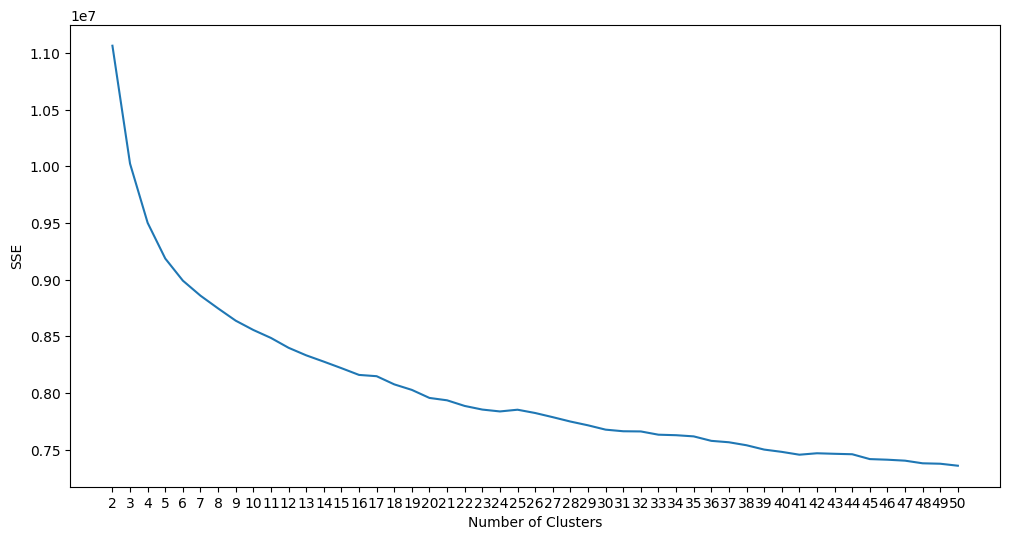

In [40]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 42,
}

sse = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs, algorithm="lloyd")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(2, 51), sse)
plt.xticks(range(2, 51))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [41]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs, algorithm="lloyd")
kmeans.fit(X)
silhouette_score(X, kmeans.labels_)

0.360577311536618

### agglomerative clustering

Иерархическую кластеризацию проведите самостоятельно. В качестве меры сходства возьмите косинусное сходство. Количество кластеров подберите или оцените то же, что подобрали для k-means.

In [42]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(X)

Визуализируйте дендрограмму.

In [43]:
import sys
sys.setrecursionlimit(10000)

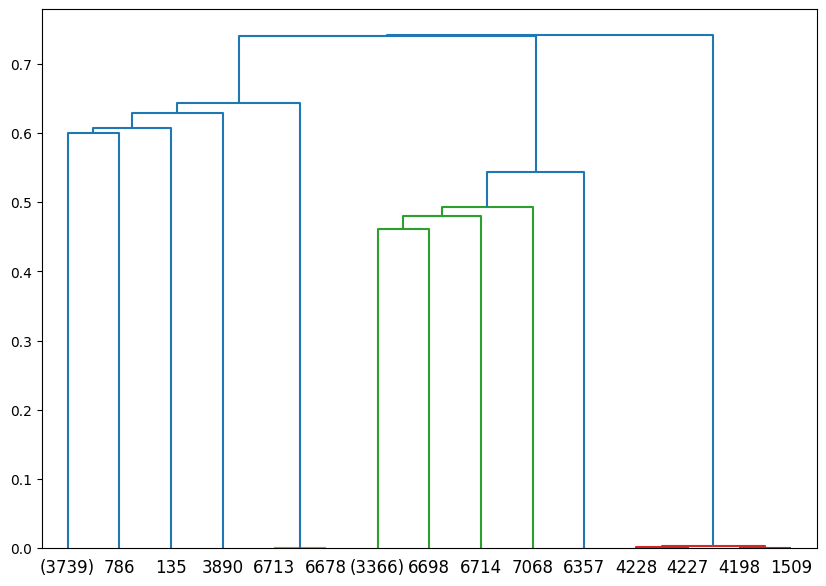

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, metric='cosine')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', p=5, truncate_mode='level', show_leaf_counts=True)
plt.show()

Оцените качество кластеризации.

In [45]:
silhouette_score(X, clustering.labels_)

0.3237818022178343

## Поиск "лишних" дисциплин

Эту часть выполните самостоятельно: постройте эмбеддинги для учебных планов по тому же принципу, по которому строили эмбеддинги для дисциплин. Затем проранжируйте все дисциплины в учебном плане по сходству с эмбеддингом плана. Выберите порог для значения сходства, ниже которого дисциплина считается "лишней".


Не нужно оценивать абсолютно все учебные планы из датасета. Можно выбрать около 10 случайных планов или тех, которые вам интересны. И оценить только их.

Обратите внимание, что типичнее для вашей выборки: малое или большое количество "лишних" дисциплин?

Проведите эксперимент: уберите из учебных планов все дисциплины, которые есть в каждом из них. Найдите "лишние" после удаления одинаковых. Оцените результат.

In [46]:
from collections import defaultdict

plan_embeddings = defaultdict(list)

for up_id, group in df_lab.groupby('up_id'):
    embeddings = np.vstack(group['embedding'].values)
    plan_embeddings[up_id] = np.mean(embeddings, axis=0)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

df_lab['up_embedding'] = df_lab['up_id'].apply(lambda x: plan_embeddings[x])

In [48]:
df_lab.head()

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,up_embedding
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...","[0.9039555484920635, 0.394014660873016, -0.818..."
1,2626,6938,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...","[0.7857745483969466, 0.4767708139694657, -0.67..."
2,2626,6974,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...","[0.46331006772727296, 0.5125574003030302, -0.4..."
3,2626,7014,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...","[0.7830041928999999, 0.5277901778499998, -0.63..."
4,2626,7136,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...","[0.49730176067796633, 0.5428707162146891, -0.2..."


In [49]:
df_lab['up_course_similarity'] = df_lab.apply(
    lambda row: cosine_similarity([row['embedding']], [row['up_embedding']])[0][0], axis=1
)

Посмотрим на метрики для нашей ОП по профильной и непрофильной дисциплинам

In [50]:
df_lab[(df_lab['up_title'] == 'Интеллектуальные системы в гуманитарной сфере') & (df['course_title'] == 'Методы оптимизации')]

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,up_embedding,up_course_similarity
14741,10787,6906,Курс нацелен на формирование у обучающихся ком...,Комбинаторная оптимизация. Математическое прог...,Оптимизация на графах. Дискретное программиров...,Методы оптимизации,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2018,"Специализация ""Интеллектуальный анализ данных""",Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[1.11879148, 1.0, 1.00205827, 0.0, 5.41543424,...","[1.1141266232167837, 0.4812924000699303, -0.61...",0.461996
14743,10787,6940,Курс нацелен на формирование у обучающихся ком...,Комбинаторная оптимизация. Математическое прог...,Оптимизация на графах. Дискретное программиров...,Методы оптимизации,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2019,"Специализация ""Интеллектуальный анализ данных""",Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[1.11879148, 1.0, 1.00205827, 0.0, 5.41543424,...","[0.961931379580838, 0.5498920484431137, -0.609...",0.394842
14755,10808,7162,Курс нацелен на формирование у обучающихся ком...,Управление в условиях неопределенности. Матема...,Дискретное программирование. Теория управления...,Методы оптимизации,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2021,Модуль обязательных дисциплин,Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[7.43950456, 2.0, 6.09006643, 1.0, 2.69710988,...","[0.6620824245023698, 0.5733115284834122, -0.10...",0.370346
34290,16062,7081,Курс нацелен на формирование у обучающихся ком...,Комбинаторная оптимизация. Математическое прог...,Оптимизация на графах. Дискретное программиров...,Методы оптимизации,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2020,"Специализация ""Интеллектуальный анализ данных""",Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[-0.29112035, 0.90907705, 0.5636374, 0.4254559...","[0.7013860618536587, 0.5474578039999999, -0.42...",-0.032355
39105,19187,7247,Курс нацелен на формирование у обучающихся ком...,Комбинаторная оптимизация. Математическое прог...,Оптимизация на графах. Дискретное программиров...,Методы оптимизации,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2022,Профильный профессиональный модуль,Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[1.11879148, 1.0, 1.00205827, 0.0, 5.41543424,...","[0.7307043828930819, 0.6472156227044024, -0.54...",0.419062


In [51]:
df_lab[(df_lab['up_title'] == 'Интеллектуальные системы в гуманитарной сфере') & (df['course_title'] == 'Философия')]

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,up_embedding,up_course_similarity
26984,15101,6906,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,Синтаксис и семантика естественного языка. Зна...,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0666205, -0.52953583, -0.0682788, -0.761045...","[1.1141266232167837, 0.4812924000699303, -0.61...",0.050978
27008,15101,6940,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,Синтаксис и семантика естественного языка. Зна...,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0666205, -0.52953583, -0.0682788, -0.761045...","[0.961931379580838, 0.5498920484431137, -0.609...",0.029832
27043,15101,7081,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,Синтаксис и семантика естественного языка. Зна...,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0666205, -0.52953583, -0.0682788, -0.761045...","[0.7013860618536587, 0.5474578039999999, -0.42...",0.013970
27058,15101,7162,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,Синтаксис и семантика естественного языка. Зна...,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0666205, -0.52953583, -0.0682788, -0.761045...","[0.6620824245023698, 0.5733115284834122, -0.10...",0.022572
38830,18980,7247,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2022,Мышление,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915887, -0.930464...","[0.7307043828930819, 0.6472156227044024, -0.54...",-0.006902


У профильной дисциплины больший вес

ставим порог вхождения 0.2

Для примера возьмем 10 учебных планов:

*   Интеллектуальные системы в гуманитарной сфере 2020 (id 7081)
*   Интеллектуальные системы в гуманитарной сфере 2021 (id 7162)
*   Интеллектуальные системы в гуманитарной сфере 2022 (id 7247)
*   Управление технологическими инновациями 2021 (id 7087)
*   Бизнес-информатика 2021 (id 7094)
*   Информатика и программирование 2020 (id 6974)
*   Программирование и интернет-технологии 2020 (id 7011)
*   Прикладная и теоретическая физика 2022 (id 7239)
*   Лазерная фотоника и оптоэлектроника 2020 (id 7304)
*   Робототехника и искусственный интеллект 2021 (id 7082)
   



In [52]:
threshold = 0.2

df_lab['is_useful'] = df_lab['up_course_similarity'].apply(lambda x: x >= threshold)

In [53]:
ids = [7081, 7162, 7247, 7087, 7094, 6974, 7011, 7239, 7304, 7082]

In [54]:
useful_dis = df_lab.groupby('up_id')['is_useful'].mean()
useful_dis.loc[ids]

up_id
7081    0.463415
7162    0.478673
7247    0.528302
7087    0.473214
7094    0.522321
6974    0.449495
7011    0.366337
7239    0.526786
7304    0.492891
7082    0.472340
Name: is_useful, dtype: float64

In [55]:
useless_dis = df_lab[(df_lab['is_useful'] == False) & df_lab['up_id'].isin(ids)]
common_useless_dis = useless_dis.groupby('course_id').filter(lambda x: len(x) == len(ids))

In [56]:
common_useless_dis['course_title'].unique()

array(['Основы финансовой грамотности', 'Анализ и принятие решений (АПР)'],
      dtype=object)

## Генерация содержания

В этой части работы вам предлагается повторить пайплайн дообучения модели [LLaMA](https://github.com/facebookresearch/llama) (LLM с открытым исходным кодом) из туториала: https://colab.research.google.com/drive/1tG9eqttfnqHoQqmsiacywUG9ilUhoiCk?usp=sharing#scrollTo=qL5i358PRGgu

С текстовым описанием: https://www.datacamp.com/tutorial/fine-tuning-llama-2

Если памяти или ресурсов колаба не хватит, то попробуйте без дообучения. Но результат будет хуже.

Выберите 10-15 дисциплин (случайных или интересных вам) и с помощью модели сгенерируйте возможное описание дисциплины.

Постройте эмбеддинг для полученного описания. Оцените близость полученного эмбеддинга и того, что у вас уже был с момента создания word2vec.

Среди выбранных вами дисциплин найдите те, которые реализуются больше одного года. Изучите их следующим образом:

1. Оцените, насколько содержательно близки дисциплины разных лет.
2. Оцените, к дисциплине какого года ближе всего сгенерированное содержание.

Формат промта

In [57]:
prompt = "<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин в ИТМО. Сгенерируй описание для введенной дисциплины %s [/INST] %s"

In [58]:
!pip install accelerate bitsandbytes peft transformers trl datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00


In [59]:
# Файнтюнинг
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [60]:
base_model = "NousResearch/Llama-2-7b-chat-hf"

In [61]:
prepared_dataset = df_to_clust.apply(lambda row: row['course_title'] + " " + row['full_description'], axis=1)

prepared_dataset = pd.DataFrame(prepared_dataset, columns=['text'])

prepared_dataset.to_csv('prepared_for_llama.csv', index=False)

dataset = load_dataset('csv', data_files='prepared_for_llama.csv', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [62]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [63]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [64]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [65]:
# Load LoRA configuration
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
# Set training parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_args,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/7118 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: ignored

In [66]:
logging.set_verbosity(logging.CRITICAL)

prompt = "<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин университета ИТМО. Сгенерируй описание для дисциплины %s. Твой ответ не должен содержать ничего, кроме самого описания. [/INST]"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)
result = pipe(prompt % "Философия")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин университета ИТМО. Сгенерируй описание для дисциплины Философия. Твой ответ не должен содержать ничего, кроме самого описания. [/INST]  Конечно! Вот описание для дисциплины "Философия":

"Философия - это дисциплина, которая изучает основные вопросы и проблемы философской мысли. Она рассматривает вопросы, связанные с пониманием и объяснением истины, морали, бытия, сознания и других философских тем. В рамках этой дисциплины преподаватели и студенты изучают различные философские теории и идеи, а также анализируют их влияние на нашу жизнь и общество. Она помогает студентам развивать критическое мышление, понимание различных точек зрения и способность мыслить на глубоком уровне. В результате, студенты могут лучше понимать мир вокруг них и находить свой путь в жизни."


In [67]:
examples = df_to_clust[:10]
examples

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...",1
6,2627,7146,"Курс ""Введение в цифровую культуру и программи...",Управление разработкой в ИТ. Базовые инструмен...,Инструментарий разработчика. IDE. CI_CD. Систе...,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[-1.32818609, 1.0, -1.80258706, 1.0, 5.2649810...",7
7,2628,6881,Дисциплина направлена на формирование понимани...,Введение. Реализация систем управления базами ...,Сложные запросы к БД Деканат. Процедуры и функ...,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[0.29277602, -0.2072225, -0.4620403, 0.3256944...",1
11,2631,6881,Дисциплина направлена на формирование системат...,Линейные коды. Сверточные коды. Коды с малой п...,Линейные коды. Сверточные коды. Коды с малой п...,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[1.48781165, 1.0, 5.47151685, 1.0, 8.9022316, ...",9
14,2635,6859,Целью освоения дисциплины является достижение ...,Иностранный язык для академических целей. Осно...,Исторические процессы и события.. Технологии б...,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[4.63760674, 1.0, 7.72395194, 1.0, 1.96419179,...",3
91,2637,6859,Данный курс сформирован на основе лучших дост...,Визуальное сопровождение выступления.. Комуник...,Аргументация и аргументы.. Формирование навыка...,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...","['техника', 'публичный', 'выступление', 'перег...","[-0.06331042, 0.57548314, -0.4874388, 0.991223...",1
133,2640,6859,"Дисциплина охватывает круг вопросов, связанных...",Типовые звенья (программа онлайн-курса). Точно...,Структурные схемы и структурные преобразования...,Теория автоматического управления,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления. Дисциплина ...,"['теория', 'автоматический', 'управление', 'ди...","[5.63877106, 1.0, -1.01177287, 0.0, 2.44194642...",0
249,2641,6859,Что общего между умным чайником и металлургиче...,"Высокий уровень разработки КФС. Технологии, пр...",Аппаратная часть кибер-физических систем. Новы...,Основы проектирования киберфизических систем,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Основы проектирования киберфизических систем. ...,"['основа', 'проектирование', 'киберфизический'...","[0.46099976, -0.57028353, 0.20339233, -0.23354...",1
365,2642,6859,Дициплина предназначена для изучения студентам...,Неделя 7. Тестирование программного обеспечени...,Тестирование №1. Контроль и управление рисками...,Методы и средства программного обеспечения,All_levels,12.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Методы и средства программного обеспечения. Ди...,"['метод', 'с

In [68]:
from tqdm.auto import tqdm
tqdm.pandas()

In [69]:
def generate_description(course_title):
    text = prompt % course_title
    result = pipe(text)[0]['generated_text']
    return result.split('[/INST]')[1].strip()


In [70]:
examples['generated_description'] =examples['course_title'].progress_apply(generate_description)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-70-d26ee7218213>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples['generated_description'] =examples['course_title'].progress_apply(generate_description)


In [71]:
examples.to_csv("generated_descriptions.csv", index=False)

In [72]:
examples['generated_description']

0      Конечно! Вот описание для дисциплины "Философи...
6      Конечно! Вот описание для дисциплины "Введение...
7      Конечно! Вот описание для дисциплины "Проектир...
11     Sure, I'd be happy to help! Here is a possible...
14     Конечно! Вот описание для дисциплины "Иностран...
91     Title: Techniques of Public Speaking, Negotiat...
133    Конечно! Вот описание для дисциплины Теория ав...
249    Конечно! Вот описание для дисциплины "Основы п...
365    Конечно! Вот описание для дисциплины "Методы и...
485    Конечно! Вот описание для дисциплины "Основы к...
Name: generated_description, dtype: object

In [73]:
examples['processed_generated_description'] = examples['generated_description'].apply(text_to_wordlist)

<ipython-input-73-5fe893c47066>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples['processed_generated_description'] = examples['generated_description'].apply(text_to_wordlist)


In [74]:
from gensim.models import Word2Vec

In [75]:
w2v_model = Word2Vec.load("fin_w2v")
examples['generated_embedding'] = examples['processed_generated_description'].apply(lambda x: embed(x, w2v_model))

<ipython-input-75-af2dd46182d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples['generated_embedding'] = examples['processed_generated_description'].apply(lambda x: embed(x, w2v_model))


In [76]:
examples.to_csv("generated_description_embeddings.csv", index=False)

In [77]:
examples.head(3)

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster,generated_description,processed_generated_description,generated_embedding
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...",1,"Конечно! Вот описание для дисциплины ""Философи...","[описание, дисциплина, философия, философия, э...","[0.6174107, 0.4900252, 0.007978508, -0.3353144..."
6,2627,7146,"Курс ""Введение в цифровую культуру и программи...",Управление разработкой в ИТ. Базовые инструмен...,Инструментарий разработчика. IDE. CI_CD. Систе...,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[-1.32818609, 1.0, -1.80258706, 1.0, 5.2649810...",7,"Конечно! Вот описание для дисциплины ""Введение...","[описание, дисциплина, введение, цифровой, кул...","[0.4073724, -0.029859299, 0.31223935, -0.26316..."
7,2628,6881,Дисциплина направлена на формирование понимани...,Введение. Реализация систем управления базами ...,Сложные запросы к БД Деканат. Процедуры и функ...,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[0.29277602, -0.2072225, -0.4620403, 0.3256944...",1,"Конечно! Вот описание для дисциплины ""Проектир...","[описание, дисциплина, проектирование, база, д...","[-0.22411159, 0.027016187, 0.61432105, -0.2576..."


In [78]:
from sklearn.metrics.pairwise import cosine_similarity

examples['natural_generated_similarity'] = examples.apply(
    lambda row: cosine_similarity([row['embedding']], [row['generated_embedding']])[0][0], axis=1
)

<ipython-input-78-cc5186b2a991>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples['natural_generated_similarity'] = examples.apply(


In [79]:
examples

,course_id,up_id,description,section,topic,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,prep_description,embedding,cluster,generated_description,processed_generated_description,generated_embedding,natural_generated_similarity
0,2626,6905,Курс «Философия» даёт целостное представление ...,Мышление и предметный мир. Соматическая опреде...,"Этическое измерение науки, искусства, повседне...",Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[1.0711099, -0.7598642, -0.00915885, -0.930464...",1,"Конечно! Вот описание для дисциплины ""Философи...","[описание, дисциплина, философия, философия, э...","[0.6174107, 0.4900252, 0.007978508, -0.3353144...",0.464654
6,2627,7146,"Курс ""Введение в цифровую культуру и программи...",Управление разработкой в ИТ. Базовые инструмен...,Инструментарий разработчика. IDE. CI_CD. Систе...,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[-1.32818609, 1.0, -1.80258706, 1.0, 5.2649810...",7,"Конечно! Вот описание для дисциплины ""Введение...","[описание, дисциплина, введение, цифровой, кул...","[0.4073724, -0.029859299, 0.31223935, -0.26316...",-0.086211
7,2628,6881,Дисциплина направлена на формирование понимани...,Введение. Реализация систем управления базами ...,Сложные запросы к БД Деканат. Процедуры и функ...,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[0.29277602, -0.2072225, -0.4620403, 0.3256944...",1,"Конечно! Вот описание для дисциплины ""Проектир...","[описание, дисциплина, проектирование, база, д...","[-0.22411159, 0.027016187, 0.61432105, -0.2576...",0.758067
11,2631,6881,Дисциплина направлена на формирование системат...,Линейные коды. Сверточные коды. Коды с малой п...,Линейные коды. Сверточные коды. Коды с малой п...,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[1.48781165, 1.0, 5.47151685, 1.0, 8.9022316, ...",9,"Sure, I'd be happy to help! Here is a possible...","[sure, happy, help, possible, oversight, cours...","[0.4367039, -0.84761006, 0.16178674, -0.011361...",0.105528
14,2635,6859,Целью освоения дисциплины является достижение ...,Иностранный язык для академических целей. Осно...,Исторические процессы и события.. Технологии б...,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[4.63760674, 1.0, 7.72395194, 1.0, 1.96419179,...",3,"Конечно! Вот описание для дисциплины ""Иностран...","[описание, дисциплина, иностранный, язык, дисц...","[-1.1928037, 1.8637965, 1.0307779, -0.29429004...",0.107231
91,2637,6859,Данный курс сформирован на основе лучших дост...,Визуальное сопровождение выступления.. Комуник...,Аргументация и аргументы.. Формирование навыка...,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...","['техника', 'публичный', 'выступление', 'перег...","[-0.06331042, 0.57548314, -0.4874388, 0.991223...",1,"Title: Techniques of Public Speaking, Negotiat...","[title, techniques, public, speaking, negotiat...","[0.1744921, -0.7521113, 0.08764811, 0.49402133...",-0.282197
133,2640,6859,"Дисциплина охватывает круг вопросов, связанных...",Типовые звенья (программа онлайн-курса). Точно...,Структурные схемы и структурные преобразования...,Т